### Importing necessary modules

In [1]:
import torch
print(torch.__version__) 

1.3.1+cpu


In [2]:
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
from tensorflow.keras.callbacks import TensorBoard
from time import time

### Read the data

In [7]:
data = pd.read_csv("q1.csv")

## Data Exploration & Preprocessing

In [8]:
data.head()

,img_id,ans,marks
0,IMG01,ଇଂଗରେଜକଂ ସାମରାଜ୍ୟ କୁ ସୁଦୃଢ କରିବା ପାଇଁ ୱେଲସେଲି ...,5.0
1,IMG02,ଇଂଗରେଜକଂ ପ୍ରଭାବିତ ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ରାଜ୍ୟାଭିଳ...,5.0
2,IMG03,NaN,3.0
3,IMG04,ସାମନ୍ତ ସନ୍ଧି ପ୍ରଥା ୱେଲସେଲି ପ୍ରଣୟନ କରିଥିଲେ|ଏହାର...,4.0
4,IMG05,ସାମନ୍ତ ସନ୍ଧି ଲର୍ଡ଼ ମାକଏଲେକଂ ଦ୍ୱାରା ପ୍ରଣୀତ ହୋଇଥ...,1.0


In [9]:
# removing the nan ans from the dataframe
data = data[data['ans'].notna()]
data.head()

,img_id,ans,marks
0,IMG01,ଇଂଗରେଜକଂ ସାମରାଜ୍ୟ କୁ ସୁଦୃଢ କରିବା ପାଇଁ ୱେଲସେଲି ...,5.0
1,IMG02,ଇଂଗରେଜକଂ ପ୍ରଭାବିତ ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ରାଜ୍ୟାଭିଳ...,5.0
3,IMG04,ସାମନ୍ତ ସନ୍ଧି ପ୍ରଥା ୱେଲସେଲି ପ୍ରଣୟନ କରିଥିଲେ|ଏହାର...,4.0
4,IMG05,ସାମନ୍ତ ସନ୍ଧି ଲର୍ଡ଼ ମାକଏଲେକଂ ଦ୍ୱାରା ପ୍ରଣୀତ ହୋଇଥ...,1.0
5,IMG06,ଭାରତରେ ଇଂଗ୍ରେଜ଼ ମାନଂକ ସାମ୍ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ୱ...,5.0


In [10]:
data.reset_index(drop= True, inplace= True)  # after droping the index gets reorganised, resetting it here

In [11]:
data.count()

img_id    67
ans       67
marks     67
dtype: int64

In [12]:
data.describe(include = 'all')

,img_id,ans,marks
count,67,67,67.000000
unique,67,67,NaN
top,IMG50,ସାମନ୍ତ ସନ୍ଧି ପ୍ରଥା ଇଂଗ୍ରେଜ଼ ସରକାର ନିଜ ସ୍ୱାର୍ଥ ...,NaN
freq,1,1,NaN
mean,NaN,NaN,3.649254
std,NaN,NaN,1.544823
min,NaN,NaN,0.000000
25%,NaN,NaN,3.000000
50%,NaN,NaN,4.000000
75%,NaN,NaN,5.000000


## Mark Distribution:

In [13]:
data = data.astype({'marks' : int})

In [14]:
data.marks.unique()

array([5, 4, 1, 3, 2, 0])

In [15]:
len(data.marks.unique())

6

In [16]:
data['marks'].value_counts(sort = True, ascending = True)

0     4
1     5
2     7
3    10
4    15
5    26
Name: marks, dtype: int64

In [17]:
data['marks'].value_counts().sort_index()

0     4
1     5
2     7
3    10
4    15
5    26
Name: marks, dtype: int64

In [18]:
data['marks'].value_counts().sort_index().tolist()

[4, 5, 7, 10, 15, 26]

In [19]:
data['marks'].value_counts().sort_index().index.tolist()

[0, 1, 2, 3, 4, 5]

<BarContainer object of 6 artists>

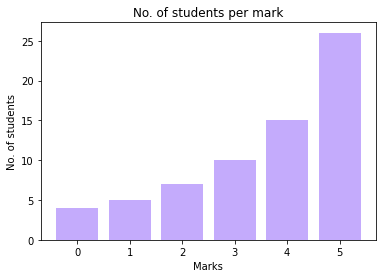

In [20]:
x = data['marks'].value_counts().sort_index().index.tolist()
y = data['marks'].value_counts().sort_index().tolist()
xpos = np.arange(len(x))
plt.xticks(xpos, x)
plt.xlabel('Marks')
plt.ylabel('No. of students')
plt.title('No. of students per mark')
plt.bar(xpos, y, color='#c4abfc')

## Feature Extraction - no_of_sent

In [21]:
sent = data.iloc[0]['ans'].split('|')
sent[:-1]

['ଇଂଗରେଜକଂ ସାମରାଜ୍ୟ କୁ ସୁଦୃଢ କରିବା ପାଇଁ ୱେଲସେଲି ଏକ ପ୍ରଥା ଆରଂଭ କରିଥିଲେ ଜାହର ନାମ ଥିଲା ଅଧିନତା ମୁଳକ ମିତ୍ରତା ଓ ସାମନ୍ତ ସନ୍ଧି',
 'ଜେଉଁ ଦେସିୟ ରାଜା ଏହାକୁ ଗ୍ରହଣ କରତିଂ ସେମାନେ ଇଂଗରେଜ ସରକାରକଂ ବିନା ଅନୂମତିରେ ଅନ୍ୟ ଦେଶିୟ ବା ବିଦେଶୀ ରାଜ୍ୟ ସହ ସବଂଧ ରଖିପାରିବେ ନାହିଂ',
 'ସତ୍ର ଅନୁଜାଇ ସେହି ରାଜା କୁଂ ଦଲେ ଇଂଗରେଜ ସୈନ୍ୟକୁ ନିଜ ରାଜ୍ୟ ରେ ଦରମା ଦେଇ ରଖିବେ',
 'ଯଦି ଅର୍ଥ ଦବାକୁ ସାମର୍ଥୟ୍ ନଥିବେ ଇଂଗରେଜ ମାନକ୍କୁଂ ତାକ୍କଂ ରାଜ୍ୟର ଅର୍ଧେକ ଅଂଶ ଦେବାକୁ ପଦିବ',
 'ହାଇଦ୍ରାବାଦର ନବାବ ଓ ଅଯୋଧ୍ୟାର ନିଜାମ ଏହାକୁ ଗ୍ରହଣ କରିଥିଲେ',
 'ପରେ ସିନଧିଆ ଓ ଭୋସଲାର ଶାସକ ଏହି ସନ୍ଧି ଗ୍ରହଣ କାଲେ',
 'ଏହାପରେ ଜୋଧପୁର ଜୟପୁର ରାଜପୁତାନା ପରି ଅନେକ ରାଜ୍ୟର ରାଜା ଏହି ସନ୍ଧି ଗ୍ରହଣ କଲେ']

In [22]:
len(sent[:-1])

7

In [23]:
%%time

# creating a new series
no_of_sent = pd.Series([], dtype = int) 

for i in range(len(data)):
    sent = data.iloc[i]['ans'].split('|')
    no_of_sent[i] = len(sent[:-1])
    
# adding the created series into the dataframe at position 2
data.insert(2, "no_of_sent", no_of_sent) 

CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 115 ms


In [24]:
data.head()

,img_id,ans,no_of_sent,marks
0,IMG01,ଇଂଗରେଜକଂ ସାମରାଜ୍ୟ କୁ ସୁଦୃଢ କରିବା ପାଇଁ ୱେଲସେଲି ...,7,5
1,IMG02,ଇଂଗରେଜକଂ ପ୍ରଭାବିତ ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ରାଜ୍ୟାଭିଳ...,9,5
2,IMG04,ସାମନ୍ତ ସନ୍ଧି ପ୍ରଥା ୱେଲସେଲି ପ୍ରଣୟନ କରିଥିଲେ|ଏହାର...,5,4
3,IMG05,ସାମନ୍ତ ସନ୍ଧି ଲର୍ଡ଼ ମାକଏଲେକଂ ଦ୍ୱାରା ପ୍ରଣୀତ ହୋଇଥ...,5,1
4,IMG06,ଭାରତରେ ଇଂଗ୍ରେଜ଼ ମାନଂକ ସାମ୍ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ୱ...,6,5


### Relationship between no. of sentences and marks :-

In [25]:
data.no_of_sent.unique()

array([ 7,  9,  5,  6,  3,  4,  8,  2, 10, 11])

In [26]:
len(data.no_of_sent.unique())

10

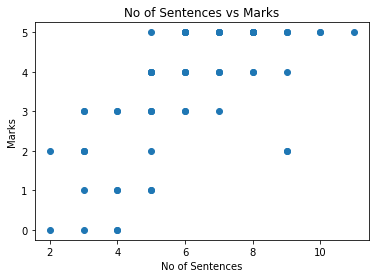

In [27]:
plt.xlabel("No of Sentences")
plt.ylabel("Marks")
plt.title("No of Sentences vs Marks")
plt.scatter(data["no_of_sent"], data["marks"])

## Feature Extraction - no_of_words

In [28]:
%%time

# creating a new series
no_of_words = pd.Series([], dtype = int) 

for row_index,row in data.iterrows():
    no = len(tokenize(row['ans'], 'or'))
    no_of_words[row_index] = no
    
# adding the created series into the dataframe at position 2
data.insert(2, "no_of_words", no_of_words)

CPU times: user 4.84 s, sys: 29.1 ms, total: 4.87 s
Wall time: 4.9 s


In [29]:
data.head()

,img_id,ans,no_of_words,no_of_sent,marks
0,IMG01,ଇଂଗରେଜକଂ ସାମରାଜ୍ୟ କୁ ସୁଦୃଢ କରିବା ପାଇଁ ୱେଲସେଲି ...,178,7,5
1,IMG02,ଇଂଗରେଜକଂ ପ୍ରଭାବିତ ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ରାଜ୍ୟାଭିଳ...,211,9,5
2,IMG04,ସାମନ୍ତ ସନ୍ଧି ପ୍ରଥା ୱେଲସେଲି ପ୍ରଣୟନ କରିଥିଲେ|ଏହାର...,97,5,4
3,IMG05,ସାମନ୍ତ ସନ୍ଧି ଲର୍ଡ଼ ମାକଏଲେକଂ ଦ୍ୱାରା ପ୍ରଣୀତ ହୋଇଥ...,104,5,1
4,IMG06,ଭାରତରେ ଇଂଗ୍ରେଜ଼ ମାନଂକ ସାମ୍ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ୱ...,137,6,5


In [30]:
data['no_of_words'].describe()

count     67.000000
mean     123.567164
std       42.810797
min       45.000000
25%       92.000000
50%      124.000000
75%      155.500000
max      211.000000
Name: no_of_words, dtype: float64

In [31]:
# no. of words for determing vector length(to be used for padding/trimming)
pad_length = 124  # median no of words

## Vectorising ans

In [32]:
%%time

# creating a new series
vectors = pd.Series([], dtype = float) 
    
for row_index,row in data.iterrows():
    vect = get_embedding_vectors(row['ans'], 'or')     # getting embedding vectors
#     vect = np.asarray(vect, np.float32)
#     vect = vect.flatten()
#     vect = vect.tolist()
#     if l < pad_length:
#         vect = np.pad(vect, [(0, 0), (0,0)], mode='constant', constant_values=0)
#     elif l > pad_length:
#         vect = vect[:pad_length]
    vectors[row_index] =  vect
    


/home/deepak/Documents/answer_evaluator/venv/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/deepak/Documents/answer_evaluator/venv/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'fastai.text.models.awd_lstm.AWD_LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/deepak/Documents/answer_evaluator/venv/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embe

CPU times: user 10.8 s, sys: 3.53 s, total: 14.3 s
Wall time: 16.1 s


In [33]:
print(len(vectors))
print(len(vectors[0]))
print(len(vectors[0][0]))

67
178
400


In [34]:
pad_vectors = keras.preprocessing.sequence.pad_sequences(vectors, padding="post", maxlen=pad_length, dtype='float32')

In [35]:
print(len(pad_vectors))
print(len(pad_vectors[0]))
print(len(pad_vectors[0][0]))

67
124
400


In [36]:
pad_vectors[66]

array([[-0.496279,  0.112968, -0.113734,  0.038314, ...,  1.025467, -0.184248,  0.03395 , -0.172279],
       [ 1.162245,  0.06199 , -0.267133,  0.767016, ..., -0.308538,  0.068172,  0.64482 ,  0.034435],
       [ 0.685473, -1.101344, -0.680804,  0.732977, ..., -1.129266,  0.111543, -0.235454, -0.557105],
       [-0.010023,  0.397589, -0.262637,  0.483528, ...,  0.353556, -0.112527, -0.239752,  0.26331 ],
       ...,
       [ 0.44362 ,  0.305948,  0.44205 ,  0.392269, ..., -0.050295,  0.05232 , -0.124861, -0.077766],
       [ 0.056702,  0.772429, -0.319718,  0.427432, ..., -0.789553,  0.533479, -0.464861, -0.091857],
       [-0.469678,  0.47128 ,  0.531628,  0.191129, ..., -1.005103,  0.145696, -0.057884,  0.085856],
       [-0.768368,  0.515574,  0.516326, -0.001637, ...,  0.217464,  0.571808, -0.550361,  0.962834]], dtype=float32)

In [37]:
# %%time

# # Checking if padding worked correctly 

# for row_index,row in data.iterrows():    # this prints the row index where vector length is not correct
#     if len(row['vectors']) != pad_length:
#         print(len(row['vectors'])," row index- ",row_index)

In [38]:
# # adding the created series into the dataframe at position 2
# data.insert(2, "vectors", vectors)

In [39]:
data.head()

,img_id,ans,no_of_words,no_of_sent,marks
0,IMG01,ଇଂଗରେଜକଂ ସାମରାଜ୍ୟ କୁ ସୁଦୃଢ କରିବା ପାଇଁ ୱେଲସେଲି ...,178,7,5
1,IMG02,ଇଂଗରେଜକଂ ପ୍ରଭାବିତ ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ରାଜ୍ୟାଭିଳ...,211,9,5
2,IMG04,ସାମନ୍ତ ସନ୍ଧି ପ୍ରଥା ୱେଲସେଲି ପ୍ରଣୟନ କରିଥିଲେ|ଏହାର...,97,5,4
3,IMG05,ସାମନ୍ତ ସନ୍ଧି ଲର୍ଡ଼ ମାକଏଲେକଂ ଦ୍ୱାରା ପ୍ରଣୀତ ହୋଇଥ...,104,5,1
4,IMG06,ଭାରତରେ ଇଂଗ୍ରେଜ଼ ମାନଂକ ସାମ୍ରାଜ୍ୟ ବିସ୍ତାର ପାଇଁ ୱ...,137,6,5


## Training and testing

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D

In [42]:
x_train, x_test, y_train, y_test = train_test_split(pad_vectors, data['marks'], test_size=0.2, random_state=22)

In [43]:
x_train = tf.convert_to_tensor(x_train, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)

x_test = tf.convert_to_tensor(x_test, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)

In [44]:
model = keras.Sequential()

model.add(Conv1D(input_shape=(pad_length,400), filters = pad_length, kernel_size = 40))
model.add(LSTM(96, dropout=0.2))
model.add(Dense(24,activation='sigmoid'))
model.add(Dense(6,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create a TensorBoard instance with the path to the logs directory
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

fitmodel = model.fit(x_train, y_train, epochs = 10,  verbose = 1, callbacks=[tensorboard])   # kernel size 80

results = model.evaluate(x_test, y_test)
print("Accuracy = ",results[1]*100)

Train on 53 samples
Epoch 1/10
53/53 [==============================] - 5s 89ms/sample - loss: 1.7162 - accuracy: 0.2453
Epoch 2/10
53/53 [==============================] - 1s 23ms/sample - loss: 1.4840 - accuracy: 0.5283
Epoch 3/10
53/53 [==============================] - 1s 19ms/sample - loss: 1.3423 - accuracy: 0.6792
Epoch 4/10
53/53 [==============================] - 1s 18ms/sample - loss: 1.2462 - accuracy: 0.7358
Epoch 5/10
53/53 [==============================] - 1s 20ms/sample - loss: 1.1539 - accuracy: 0.7925
Epoch 6/10
53/53 [==============================] - 1s 24ms/sample - loss: 1.0838 - accuracy: 0.8113
Epoch 7/10
53/53 [==============================] - 1s 27ms/sample - loss: 1.0235 - accuracy: 0.8113
Epoch 8/10
53/53 [==============================] - 1s 21ms/sample - loss: 0.9732 - accuracy: 0.8113
Epoch 9/10
53/53 [==============================] - 1s 16ms/sample - loss: 0.9275 - accuracy: 0.8113
Epoch 10/10
14/1 [=====================================================

In [45]:
tf.__version__

'2.0.0-rc1'

In [46]:
model.predict(x_test)

array([[0.061392, 0.040645, 0.056775, 0.121139, 0.152224, 0.567825],
       [0.06522 , 0.037935, 0.065974, 0.13081 , 0.177746, 0.522315],
       [0.053062, 0.040711, 0.06705 , 0.193838, 0.168616, 0.476722],
       [0.10135 , 0.069472, 0.130777, 0.325304, 0.18853 , 0.184568],
       ...,
       [0.05269 , 0.027503, 0.059057, 0.135421, 0.093653, 0.631676],
       [0.053403, 0.028996, 0.060268, 0.133151, 0.09882 , 0.625362],
       [0.102141, 0.06596 , 0.133351, 0.307467, 0.192131, 0.19895 ],
       [0.041662, 0.041402, 0.06093 , 0.23539 , 0.483263, 0.137354]], dtype=float32)

In [47]:
y_test

<tf.Tensor: id=3, shape=(14,), dtype=float32, numpy=array([5., 5., 5., 2., 1., 5., 3., 5., 5., 4., 5., 5., 1., 4.], dtype=float32)>

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 85, 124)           1984124   
_________________________________________________________________
lstm (LSTM)                  (None, 96)                84864     
_________________________________________________________________
dense (Dense)                (None, 24)                2328      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 2,071,466
Trainable params: 2,071,466
Non-trainable params: 0
_________________________________________________________________


In [49]:
# model.save("lstm_model.h5")

In [50]:
# from tensorflow.keras.models import load_model

In [51]:
# model_loaded = load_model('lstm_model.h5')

In [52]:
# # one time execution 
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')